In [1]:
## Run this to Setup the Environment
import cv2 as cv
from matplotlib import pyplot as plt
import os
import numpy as np
import random as rng
rootPath = 'D:/AMEP lab/BBot Database'

"""
    Purpose of this script is to capture the ellipse that surrounds the robot
    in one experiment file
    The result is not perfect, but it should capture as many data as possible
    Even if it means noise is included. All signals should be included
"""

'\n    Purpose of this script is to capture the ellipse that surrounds the robot\n    in one experiment file\n    The result is not perfect, but it should capture as many data as possible\n    Even if it means noise is included. All signals should be included\n'

In [3]:
"""
  DO NOT RUN THIS IF FRAMES ALREADY LOADED! IT TAKES LONG!
  This part of the code is for writing the input video into frames
"""
print(os.getcwd())
print(os.listdir())

cap = cv.VideoCapture(rootPath+'/input/videos/bot2run4.MOV')
if (cap.isOpened()== False):
  print("Error opening video stream or file")

# Frame number called flag
flag = 0
# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    flag+=1
    cv.imwrite("bot2run4/"+str(flag)+".jpg", frame)
  # Break the loop
  else:
    break

/content/drive/MyDrive/Colab Notebooks/BBot project
['DSC_5815.JPG', 'DSC_5816.JPG', 'DSC_5823.JPG', 'DSC_5824.JPG', 'DSC_5825.JPG', 'DSC_5826.JPG', 'bot2run3.MOV', 'bot2run3', 'image processing with bot2run3.ipynb', 'bot2run4.MOV', 'bot2run4', 'bot2run5.MOV', 'surface stats.gsheet', 'video analysis with bot2.ipynb', 'outpy.avi', 'sample_frame_bot2.jpg', 'sample_frame_bot3.jpg', 'video processing with bot2run4.ipynb']


In [5]:
## Find the video frame that would work as a background image
path = rootPath+"/input/frames/bot2run4/1.jpg" #REMEMBER: path has to use '/' instead of '\'
background = cv.imread(path)
plt.imshow(convertToDisplay(np.array(background)))

NameError: name 'reds' is not defined

Find the contrast image with only the robot \
Threshold the image so that there shows a clean robot \
Get the Stats of this robot


In [4]:
def convertToDisplay(frame):
    """
    This function helps you arrange the data output of cv.imread() which is in BGR format
    into RGB format which is the input format of plt.imshow()

    It takes a cv Mat variable and returns a np.array()
    """
    converted = np.zeros((frame.shape[0], frame.shape[1], frame.shape[2]), dtype=np.int16)
    global blues, greens, reds
    for ri, row in enumerate(frame):
        for pi, pixel in enumerate(row):
            converted[ri][pi] = [pixel[2], pixel[1], pixel[0]]
            reds += [pixel[2]]
            blues += [pixel[0]]
            greens += [pixel[1]]
    return converted

def GetEllipseFrom(frame): #frame must be a np.array()
  """
  Returns an ellipse object
  locate the robot object in the frame and identifies it with a minimum area ellipse around it
  
  """

  frame = frame.astype('uint8')
  frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

  #plt.imshow(frame)
  #Find all the contours in this frame
  contours,_= cv.findContours(image=frame,
                              mode=cv.RETR_TREE,
                              method=cv.CHAIN_APPROX_NONE,
                             )

  #Find out all the ellipse corresponding to the contours in this frame:
  minEllipse = [None]*len(contours)
  for i,c in enumerate(contours):
    if c.shape[0] > 5:
      minEllipse[i] = cv.fitEllipse(c)

  return minEllipse

In [263]:
# Picking out one frame with the robot and do Analysis on it, if it works, we do that for all frames
i = 200 
framePath = rootPath+"/input/frames/bot2run4/{}.jpg".format(i)
robot = cv.imread(framePath)

robotOnly = cv.subtract(robot, background) # Subtract background from robot, leaving only the robot image, otherwise black

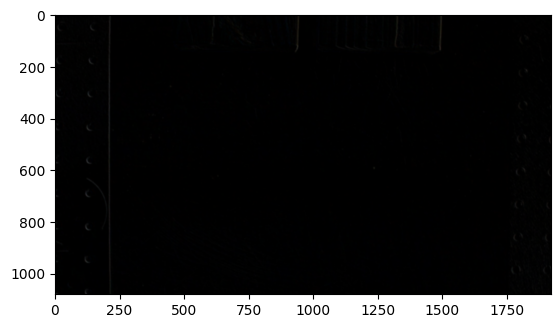

In [264]:
#Run this part to load the image again
blues = []
greens = []
reds = []
#Blur the robotOnly image
robotOnly = cv.GaussianBlur(robotOnly,(11,11),0)

#Create canvas for the new robotBinary image, which is a weighted image of the robotBinary image


robotBinary = convertToDisplay(robotOnly)
plt.imshow(robotBinary)
#This show that the robotBinary image is dimmed from the original image because of the subtraction of background


In [265]:
# Masking
robotBinary[robotBinary > 160] = 255# recommend 25 as threshold for frame 
robotBinary[robotBinary < 160] = 0

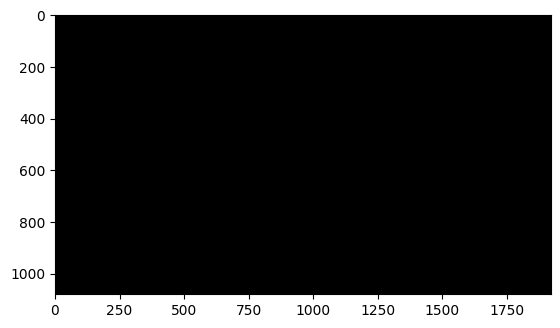

In [266]:
# find all the ellipses in the robotOnly frame
minEllipse = GetEllipseFrom(robotBinary)

# create this empty canvas from robotOnly dimensions
drawing = np.zeros((robotBinary.shape[0], robotBinary.shape[1], robotBinary.shape[2]), dtype=np.uint8)

# draw ellipse
for i, e in enumerate(minEllipse):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv.ellipse(drawing, minEllipse[i], color, 2)

plt.imshow(drawing)

In [9]:
# Store all frames as binary frames to a .npy file
# MASK IT!
path = rootPath+"/input/frames/bot2run4" #REMEMBER: path has to use '/' instead of '\'
background = cv.imread(path+'/1.jpg')

numberOfFrames = len(os.listdir(path))
center = np.zeros((numberOfFrames,2))
size = np.zeros((numberOfFrames,2))
angle = np.zeros((numberOfFrames,1))

for i in range(numberOfFrames):
    robot = cv.imread(path+'/{}.jpg'.format(i+1)) # Configure this according to the directory
    robotOnly = cv.subtract(robot, background) # Subtract background from robot, leaving only the robot image, otherwise black
    robotBinary = cv.GaussianBlur(robotOnly,(11,11),0) # Blur the image. This is Tunable parameter

    _, minEllipse = dynamicMask(robotBinary, 10)

    # Putting all the variables where they belong, indexing may create problems, but in general 
    # try-except block captures all the data
    #TODO: Need to look more into this part, since there might be signals missing because of this
    #      brute-force processing
    try:
        center[i] = minEllipse[0][0]
        size[i] = minEllipse[0][1]
        angle[i] = minEllipse[0][2]
    except:
        center[i] = (-1, -1)
        size[i] = (-1, -1)
        angle[i] = [-1]
    print('Finished Working on Frame_{}'.format(i+1))

path = rootPath+'/output/data/bot2run4/center.npy'
np.save(path, np.asarray(center))
path = rootPath+'/output/data/bot2run4/size.npy'
np.save(path, size)
path = rootPath+'/output/data/bot2run4/angle.npy'
np.save(path, angle)

Finished Working on Frame_1
Finished Working on Frame_2
Finished Working on Frame_3
Finished Working on Frame_4
Finished Working on Frame_5
Finished Working on Frame_6
Finished Working on Frame_7
Finished Working on Frame_8
Finished Working on Frame_9
Finished Working on Frame_10
Finished Working on Frame_11
Finished Working on Frame_12
Finished Working on Frame_13
Finished Working on Frame_14
Finished Working on Frame_15
Finished Working on Frame_16
Finished Working on Frame_17
Finished Working on Frame_18
Finished Working on Frame_19
Finished Working on Frame_20
Finished Working on Frame_21
Finished Working on Frame_22
Finished Working on Frame_23
Finished Working on Frame_24
Finished Working on Frame_25
Finished Working on Frame_26
Finished Working on Frame_27
Finished Working on Frame_28
Finished Working on Frame_29
Finished Working on Frame_30
Finished Working on Frame_31
Finished Working on Frame_32
Finished Working on Frame_33
Finished Working on Frame_34
Finished Working on Fra

In [ ]:
# Do findEllipse on the .npy file